# Numerické řešení Stokesova problému pomocí MKO

In [1]:
using PyPlot;

In [2]:
include("mesh.jl");

In [3]:
include("fields.jl");

In [4]:
include("operators.jl");

## Definice sítě, počátečních a okrajových podmínek

In [5]:
n = 25
m = cartesian_mesh(n,n);

In [6]:
p = ScalarField(m);
for name ∈ ["left", "right", "bottom", "top"]
    set_neumann_patch!(p, name, 0.0)
end

In [7]:
u = ScalarField(m)
set_dirichlet_patch!(u, "left", 0.0);
set_dirichlet_patch!(u, "right", 0.0);
set_dirichlet_patch!(u, "bottom", 0.0);
set_dirichlet_patch!(u, "top", 1.0);

v = ScalarField(m)
set_dirichlet_patch!(v, "left", 0.0);
set_dirichlet_patch!(v, "right", 0.0);
set_dirichlet_patch!(v, "bottom", 0.0);
set_dirichlet_patch!(v, "top", 0.0);

### Sdružený algoritmus

Soustava rovnic pro řešení Stokesova problému je
$$
    \begin{bmatrix}
    L & 0 & G_x \\
    0 & L & G_y \\
    D_x & D_y & 0
    \end{bmatrix}
    \begin{bmatrix} u \\ v \\ p \end{bmatrix}
    =
    \begin{bmatrix} b_u \\ b_v \\ b_0 \end{bmatrix}.
$$
kde $L$ je matice vzniklá aproximací $-\Delta$, $G_x$ je aproximace $\partial_x$ a $G_y$ je aproximace $\partial_y$. Podobně i $D_x$ a $D_y$.

In [8]:
eq1 = -Δ(1.0e-4, u);
eq2 = -Δ(1.0e-4, v);
eq3 = ∂x(p);
eq4 = ∂y(p);
eq5 = ∂x(u);
eq6 = ∂y(v);

In [9]:
L  = eq1.A;
Gx = eq3.A;
Gy = eq4.A;
Dx = eq5.A;
Dy = eq6.A;
O  = zeros(L);

M = [L  O  Gx;
     O  L  Gy;
     Dx Dy O];

bu = -eq1.b - eq3.b;
bv = -eq2.b - eq4.b;
b0 = -eq5.b - eq6.b;
b = [bu; bv; b0];

Matice $M$ je ale singulární!

In [10]:
#lze to overit, ale trva to dlouho
# cond(Array(M))

Přidám proto k soustavě 1 rovnici p[end]=0.

In [11]:
M[end,end] = n*n;
#cond(M)

In [12]:
sol = M \ b;

In [13]:
uu = reshape(sol[1:n*n], (n,n));
vv = reshape(sol[n*n+1:2*n*n], (n,n));
pp = reshape(sol[2*n*n+1:end], (n,n));

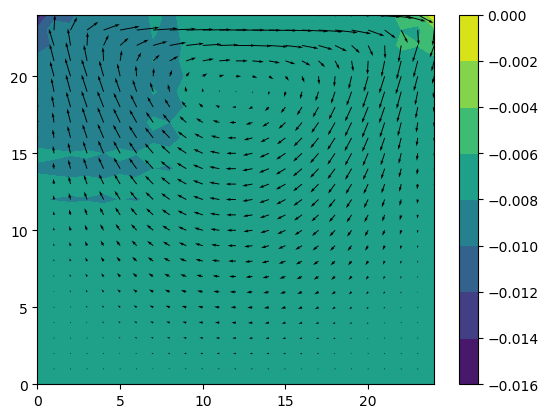

In [14]:
contourf(pp'); colorbar();
quiver(uu',vv');

## Algoritmus SIMPLE pro Stokesuv problem

Na jednotkovém čtevrci [0,1]x[0,1] řešme soustavu rovnic
\begin{align*}
- \Delta U &= - \nabla p, \\
\nabla U &= 0.
\end{align*}

s okrajovými podmínkami
$$
    U(x,y) = \left\{
    \begin{array}{ll}
        [0,0] & \text{pro } x \in [0,1] \land y=1,\\
        [0,0] & \text{pro } x=0 \lor x=1 \lor y=0.
    \end{array}
    \right.
$$
a
$$
    \frac{\partial p}{\partial n} = 0 \,\text{pro } x=0 \lor x=1 \lor y=0 \lor y=1.
$$


Diskretizace:
$$
    a_C U_C = \sum_{f} a_F U_F + Q_C - \nabla p_C = H(U) - \nabla p_C,
$$

a tedy

$$
    U_C = \frac{1}{a_C} H(U) - \frac{1}{a_C} \nabla p_C.
$$

Definujme
$$
    \hat{U}_C = \frac{1}{a_C} H(U).
$$

Rovnice kontinuity

$$
    0 = \nabla U_C = \nabla(\hat{U}_C - \frac{1}{a_C} \nabla p_C)
$$

a tedy

$$
    \nabla(\frac{1}{a_C} \nabla p_C) = \nabla(\hat{U}_C).
$$

In [15]:
U = VectorField(m)
set_dirichlet_patch!(U, "left", Vec2d(0,0));
set_dirichlet_patch!(U, "right", Vec2d(0,0));
set_dirichlet_patch!(U, "bottom", Vec2d(0,0));
set_dirichlet_patch!(U, "top", Vec2d(1,0));

In [16]:
Ueqn = - Δ(1e-4, U) + ∇(p);

In [17]:
solve!(Ueqn);

In [18]:
Ac{T}(eq::Equation{T}) = diag(eq.A);
H{T}(eq::Equation{T}) =  -eq.b .+ Ac(eq) .* eq.x .-  eq.A * eq.x;

In [19]:
ra = 1 ./ Ac(Ueqn);

In [20]:
Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);

In [21]:
ra .* H(Ueqn);

In [22]:
pEqn = Δ(ra, p) - ∇(Ubar);
pEqn.A[1,1] += 1;

In [23]:
solve!(pEqn)

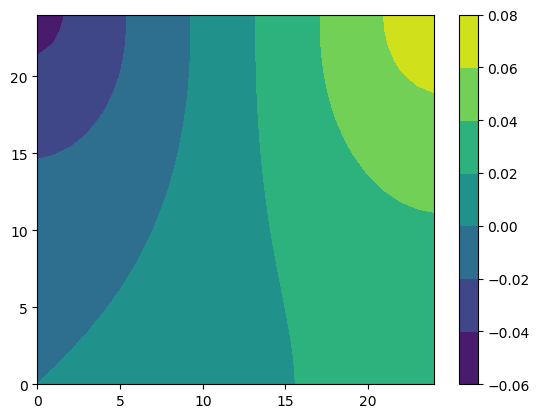

In [24]:
pp = reshape(p.values, (n,n))
contourf(pp'); colorbar();

In [25]:
U ← Ubar - ra .* ∇(p);

In [26]:
component(f::VectorField, c) = [ v[c] for v in f.values ]

component (generic function with 1 method)

In [27]:
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

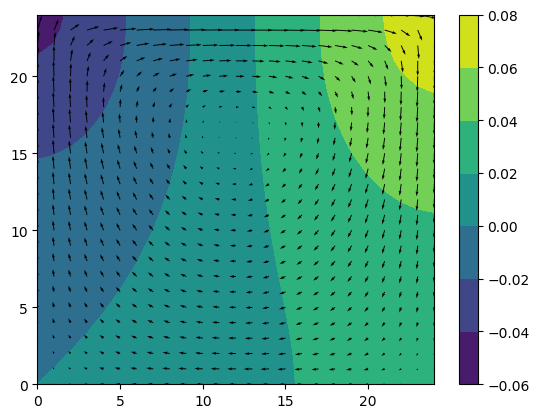

In [28]:
contourf(pp'); colorbar();
quiver(uu',vv');

In [29]:
p.values = zeros(n*n)
U.values = zeros(Vec2d,n*n)

α = 0.7
β = 0.3
ν = 1.0e-4

for iter = 0:50
    
    U_old, p_old = copy(U.values), copy(p.values)
    
    Ueqn = -Δ(ν,U)

    relax!(Ueqn, α)
    
    solve!(Ueqn + ∇(p))
    
    ra = 1 ./ Ac(Ueqn);
    
    Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);
    
    pEqn = Δ(ra, p) - ∇(Ubar);
    pEqn.A[1,1] -= n*n
    solve!(pEqn)
    
    p ← β*p + (1-β)*p_old
    U ← Ubar - ra .* ∇(p)
    
    if rem(iter,5)==0
        nxny = n*n
        pRez = norm(p_old - p.values) / nxny
        cont = norm(∇(U)) / nxny
        println(iter, "\t", pRez, "\t", cont)
    end
end

0	3.954386650172425e-5	0.015512364294590688
5	8.056242457411362e-6	0.009361903085539972
10	1.7451214787951405e-6	0.008280451401574943
15	1.6278778503934725e-6	0.008188810740230685
20	7.789914849079714e-7	0.008181419142768351
25	2.66363640986598e-7	0.00818266430096966
30	6.477468568592219e-8	0.008183988720951111
35	1.240300797816471e-8	0.008184807504245366
40	6.2822548023091696e-9	0.00818531961140619
45	6.0198278815665655e-9	0.00818566706585133
50	6.034119432226506e-9	0.008185915452409188


In [30]:
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

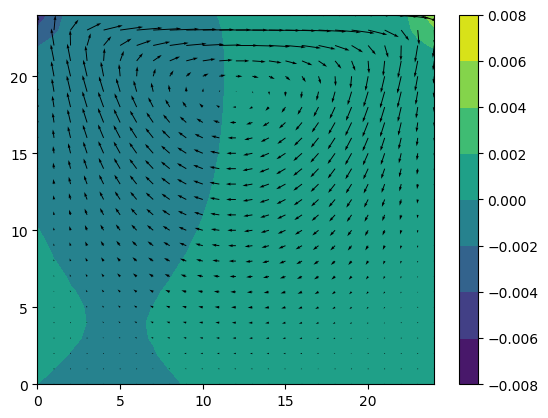

In [31]:
contourf(pp'); colorbar();
quiver(uu',vv');